# XY - Modell

In [2]:
# Standard imports for computational physics
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sqlite3
from scipy.optimize import curve_fit
from scipy.odr import ODR, RealData, Model
import scienceplots

# Pretty styling for graphs
plt.style.use(['science', 'grid', 'scatter'])
plt.rcParams["figure.figsize"] = (12, 8)

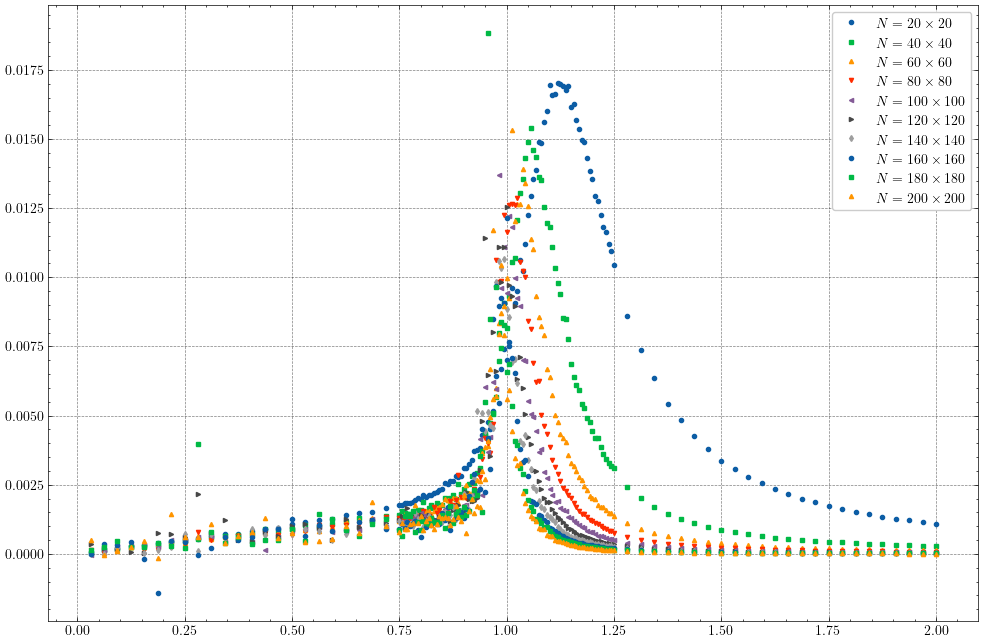

In [20]:
con = sqlite3.connect('output.sqlite')
current_run = pd.read_sql_query('SELECT id FROM runs ORDER BY created_at DESC', con).at[0, 'id'] - 1

sizes = []
maximas = []
delta_maximas = []

#run_id = \'{current_run}\' AND 
fig, ax = plt.subplots()
for size in pd.read_sql_query(f'SELECT size FROM configurations WHERE run_id = \'{current_run}\' GROUP BY size', con)['size']:
    data = pd.read_sql_query(f'SELECT temperature, magnet_suscept, energy FROM configurations WHERE run_id = \'{current_run}\' AND size = \'{size}\' ORDER BY temperature', con)
    ax.errorbar(data['temperature'], data['magnet_suscept'], label=f'$N = {size} \\times {size}$')

    sizes.append(1.0 / np.log(size)**2)

    top = data.sort_values('magnet_suscept', ascending=False).head(5)

    max_idx = data['magnet_suscept'].idxmax()
    max_temp = data.loc[max_idx]['temperature']
    delta_max_temp = np.abs(data.loc[max_idx]['temperature'] - data.loc[max_idx + 1]['temperature'])

    maximas.append(top['temperature'].mean())
    delta_maximas.append(top['temperature'].std())

#ax.set_yscale('log')
ax.legend()
fig.savefig('Energy.pdf', bbox_inches='tight')

[1.98505106 0.90769785]
[0.20255004 0.01138936]
R Squared: 0.98766360


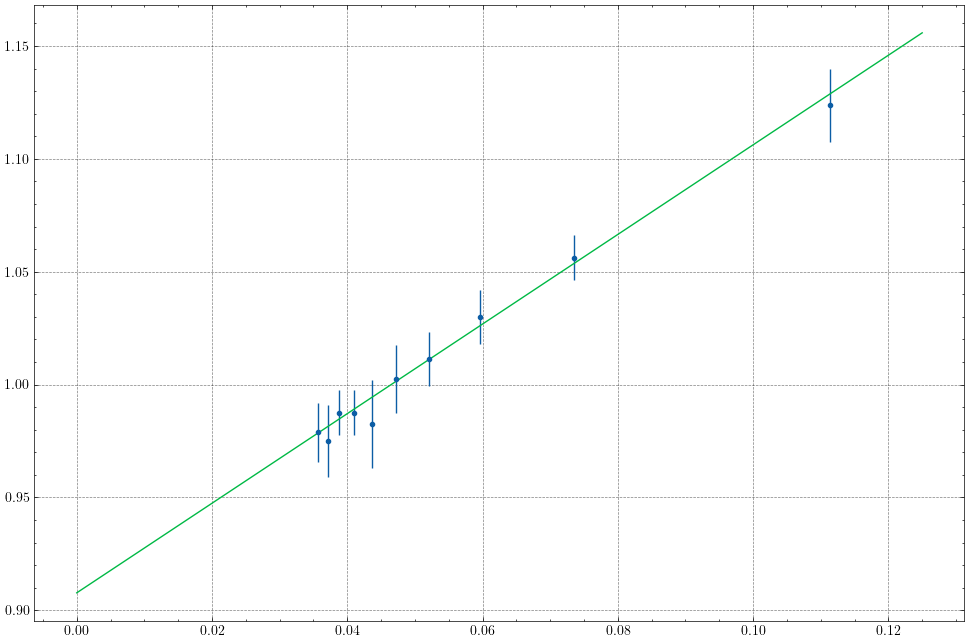

In [21]:
sizes = np.array(sizes)
maximas = np.array(maximas)
delta_maximas = np.array(delta_maximas)

fig, ax = plt.subplots()
ax.errorbar(sizes, maximas, yerr=delta_maximas)

def linear_fn(x: float, slope: float, intercept: float) -> float:
    return slope * x + intercept

popt, pcov = curve_fit(linear_fn, sizes, maximas, sigma=delta_maximas, absolute_sigma=True)
perr = np.sqrt(np.diag(pcov))
print(popt)
print(perr)

residuals = maximas - linear_fn(sizes, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((maximas - np.mean(maximas))**2)
r_squared = 1 - (ss_res / ss_tot)
print(f'R Squared: {r_squared:.8f}')

sampling = np.linspace(0, 0.125, num=100)
ax.plot(sampling, linear_fn(sampling, *popt), '-')